# Capstone Project - The Battle of Neighborhoods (Lagos, Nigeria) 
## Applied Data Science Capstone by IBM on Coursera

## Table of contents
1. [Introduction: Business Problem](#intro)
2. [Data Requirements](#data)
3. [Methodology](#methodology)
4. [Analysis](#analysis)
5. [Results](#results)
6. [Discussion](#discussion)
7. [Word Cloud](#word)
8. [Conclusion](#conclusion)


## Introduction: Problem Background  <a name="intro"></a>

This project deals with discussing the neighborhoods of **Lagos city, The commercial capital of Nigeria** (The Most populous black nation) and the commercial hub of West Africa. It is the 4th wealthiest city in Africa, fourth place behind Johannesburg, Cairo and Cape Town. 

This project would  help people planning to startup business in the city find the most ideal location.

The Foursquare API is used to access the venues in the neighborhoods. Since, it returns less venues in the neighborhoods, we would be analysing areas for which countable number of venues are obtained. Then they are clustered based on their venues using Data Science Techniques. Here the k-means clustering algorithm is used to achieve the task. Folium visualization library can be used to visualize the clusters superimposed on the map of the city. These clusters can be analyzed to help small scale business owners select a suitable location for their need such as Hotels, Restaurants or Coffee shops.

## Scrap content from wiki page
Download all necessary Library.

In [1]:
import re
import json # library to handle JSON files
import requests # library to handle requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
from pandas.io.json import json_normalize  # transform json files to pandas dataframes
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim  # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


## Data Requirements <a name="data"></a>

The Dataset is the wikipedia page of Lagos state  [link](https://en.wikipedia.org/wiki/List_of_Lagos_State_local_government_areas_by_population)

We shall explore Lagos city through its respective Local Government Areas (LGA) or Boroughs. The above link is a web page that shows the respective boroughs in Lagos State and each population figure. It's a public Wikipedia data page.

The following steps are follow to analysed the data:
<br>We scrape the web page using the beautiful soup library
<br>Follow by useing Foursquare API calls to retrieve geolocation data
<br>We shall fetch the text data using the requests library
<br>We than convert it from JSON to Pandas data frame using the json_normalize module
<br>We shall use The folium library to render the maps and plot these via The Matplotlib library. Then we shall explore respective boroughs and analyse each area as a location for Startup based on the aforementioned parameters.
<br>After this, we shall select our top location.

In [2]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_Lagos_State_local_government_areas_by_population").text
soup = BeautifulSoup(source, 'lxml')

table_text = []
my_table = soup.find_all('td')

for data in my_table:
    table_text.append(data.text)
    
relevant_table_data = table_text[4:-3]


table_dict={'LGA':[], 'Population':[]}
count = 0

for item in relevant_table_data:
    # First let's strip off the \n at the end
    item = item.strip('\n')
    try:
        item = int(item)
    except:
        # if second item after the int, append to POP
        if count > 0:
            # First let's remove the commas
            item = item.replace(',','')
            # Next let's convert to an integer so we can use it for calculations
            item = int(item)
            # Finally, let's append it to the Population list of the dictionary
            table_dict['Population'].append(item)
            count = 0
        else:
         # if first item after the int, append to LGA
            table_dict['LGA'].append(item)
            count +=1

df_lagos = pd.DataFrame(table_dict)

# Let's see the first five rows
df_lagos.head()


,LGA,Population
0,Alimosho,11456783
1,Ajeromi-Ifelodun,2000346
2,Kosofe,665421
3,Mushin,633543
4,Oshodi-Isolo,1621789


Appending the Latitude and Longitude Values:
First let's define a simple method to extract each LGA or Borough Lats and Longs data

In [3]:
def latitude_longitude(Borough):
    import time
    """ Method takes a Series object and returns
    a list of Latitude and corresponding Longitude data,
    using the geopy library.
    This method also prints out the coordinate data"""
    
    address = str(Borough)
    
    # We must define a geolocator user agent
    geolocator = Nominatim(user_agent="NG_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinates of {} are lat {} and long {}.'.format(address, latitude, longitude))
    # WARNING: we let 2 secs pass after calling each location lat/lon so that the geocode function may not crash as it crashes quite often
    # Feel free to wait a few seconds and re-run this cell if it crashes or displays an Error message.
    time.sleep(2)  
    return [latitude, longitude]


In [4]:
df_lagos['latitude'] = df_lagos['LGA'].apply(latitude_longitude)

The geograpical coordinates of Alimosho are lat 6.58434295 and long 3.257631097232365.
The geograpical coordinates of Ajeromi-Ifelodun are lat 6.455121699999999 and long 3.3359462518298724.
The geograpical coordinates of Kosofe are lat 6.581974000000001 and long 3.4148359416178415.
The geograpical coordinates of Mushin are lat 50.5182287 and long 3.2916537.
The geograpical coordinates of Oshodi-Isolo are lat 6.5400100000000005 and long 3.312414613183944.
The geograpical coordinates of Ojo are lat 45.5309774 and long 13.886159.
The geograpical coordinates of Ikorodu are lat 6.6191233 and long 3.5041271.
The geograpical coordinates of Surulere are lat 6.487201450000001 and long 3.353258726723983.
The geograpical coordinates of Agege are lat 6.6252564 and long 3.311209267702652.
The geograpical coordinates of Ifako-Ijaiye are lat 6.6636025 and long 3.289491.
The geograpical coordinates of Somolu are lat 6.5392228 and long 3.3789578.
The geograpical coordinates of Amuwo-Odofin are lat 6.44

In [5]:
df_lagos.head()

,LGA,Population,latitude
0,Alimosho,11456783,"[6.58434295, 3.257631097232365]"
1,Ajeromi-Ifelodun,2000346,"[6.455121699999999, 3.3359462518298724]"
2,Kosofe,665421,"[6.581974000000001, 3.4148359416178415]"
3,Mushin,633543,"[50.5182287, 3.2916537]"
4,Oshodi-Isolo,1621789,"[6.5400100000000005, 3.312414613183944]"


In [6]:
lon_list = []
for i, j in df_lagos.iterrows():
    lon_list.append(j.latitude[1])
    df_lagos.iat[i,2] = j.latitude[0]
      
# next let's assign the lon_list as the value of the Longitude Column

df_lagos['longitude'] = lon_list

df_lagos.head()

,LGA,Population,latitude,longitude
0,Alimosho,11456783,6.584343,3.257631
1,Ajeromi-Ifelodun,2000346,6.455122,3.335946
2,Kosofe,665421,6.581974,3.414836
3,Mushin,633543,50.518229,3.291654
4,Oshodi-Isolo,1621789,6.54001,3.312415


In [7]:
address = "Lagos"

geolocator = Nominatim(user_agent="lagos_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Lagos city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Lagos city are 6.4550575, 3.3941795.


#### Lagos Map:

Create a map of Lagos City with neighborhoods superimposed on top

In [8]:
# create map of Lagos using latitude and longitude values
Lagos_map = folium.Map(location=[latitude, longitude], zoom_start=11)    

# add markers to map
for lat, lng, LGA, Population in zip(df_lagos['latitude'], df_lagos['longitude'], 
            df_lagos['LGA'], df_lagos['Population']):
    label = '{}, {}'.format(LGA, Population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Lagos_map) 
    
Lagos_map        
        

####  Define Foursquare Credentials and Version

In [9]:
CLIENT_ID = 'I2EFWQITNIX5G3J2U5YYCLZCJEAAZKWET4XCTTJORXBNJTK3' # your Foursquare ID
CLIENT_SECRET = '0W5M2ECA0UGNRDTAJQFOMHYQO51F3ILYUTWIKDCVHG1Y0MEB' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 200

#### Explore neighborhoods in Lagos
The following function will send a explore request for each neighborhood and return the 200 most popular places in the neighborhood around 10,000 meters.

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000, limit=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Lets use the above function on the Lagos neighborhoods dataframe and store the venues data returned in the Lagos_venues pandas dataframe.

In [11]:
Lagos_venues = getNearbyVenues(names = df_lagos['LGA'],
                                 latitudes = df_lagos['latitude'],
                                 longitudes = df_lagos['longitude']
                                 )

print(Lagos_venues.shape)
Lagos_venues.head()

(1140, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alimosho,6.584343,3.257631,Ipaja market ipaja,6.602248,3.255585,Market
1,Alimosho,6.584343,3.257631,Wings Restaurant,6.576023,3.325612,Restaurant
2,Alimosho,6.584343,3.257631,Tantalisers,6.649299,3.265609,Burger Joint
3,Alimosho,6.584343,3.257631,De Grange suites & bar,6.602309,3.267038,Bar
4,Alimosho,6.584343,3.257631,"National Stadium, Surulere",6.593562,3.304300,Athletics & Sports


A total of 1144 venues were obtained. Now lets check the number of venues returned per neighborhood

In [12]:
Lagos_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agege,92,92,92,92,92,92
Ajeromi-Ifelodun,56,56,56,56,56,56
Alimosho,41,41,41,41,41,41
Amuwo-Odofin,22,22,22,22,22,22
Apapa,100,100,100,100,100,100
Badagry,5,5,5,5,5,5
Epe,28,28,28,28,28,28
Eti-Osa,52,52,52,52,52,52
Ifako-Ijaiye,62,62,62,62,62,62


From the above dataframe we can see that Somolu, Oshodi-Isolo, Lagos Mainland and Apapa returned the highest number of venues i.e. 100 respectively. Now lets check the unique categories of all the venues returned.

In [13]:
print('There are {} uniques categories.'.format(len(Lagos_venues['Venue Category'].unique())))

There are 133 uniques categories.


## Methodology <a name="methodology"></a>

Now, with the neighborhoods data We also have the most popular venues in each neighborhood obtained using Foursquare API. A total of **1144 venues** have been obtained in the whole city and **135 unique categories**. But as seen we have multiple neighborhoods with less than 10 venues returned. In order to create a good analysis let's consider only the neighborhoods with more than 10 venues.

We can perform one hot encoding on the obtained data set and use it find the 10 most common venue category in each neighborhood. Then clustering can be performed on the dataset. Here **K - Nearest Neighbor** clustering technique have been used. To find the optimal number of clusters silhouette score metric technique is used.

The clusters obtained can be analyzed to find the major type of venue categories in each cluster. This data can be used to suggest business people, suitable locations based on the category.

## Analysis <a name="analysis"></a>

First, we visualize the number of venues obtained in all the neighborhoods of Lagos

<AxesSubplot:xlabel='Neighborhood'>

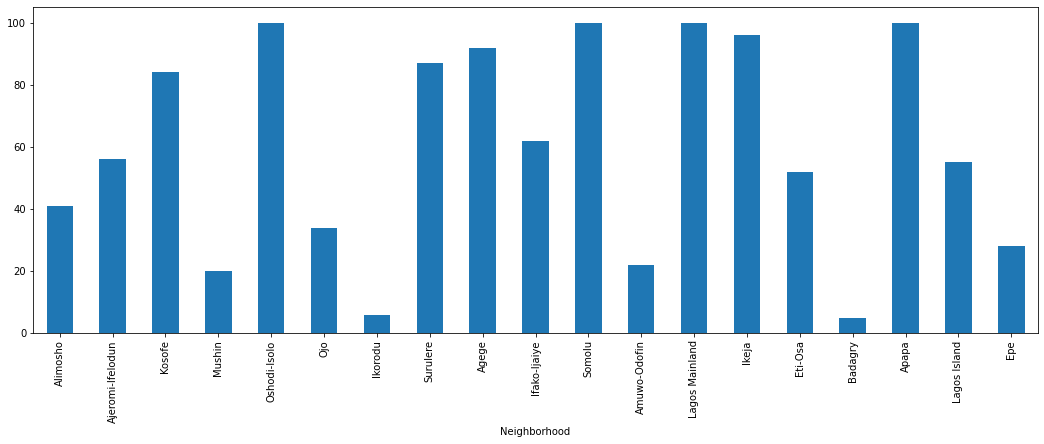

In [14]:
df = Lagos_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

As shown above, there are neighborhoods with less than 20 venues which can be remove before performing the analysis to obtain better results. The following plot shows only the neighborhoods from which 20 or more than 10 venues were obtained.

<AxesSubplot:xlabel='Neighborhood'>

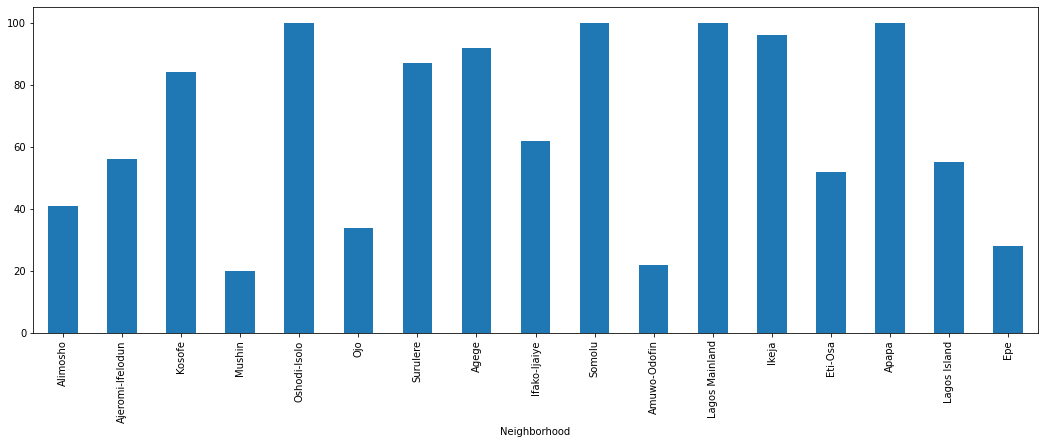

In [15]:
df = df[df >= 20]
df.plot.bar(figsize=(18,6))

Lets create a new dataframe, Lagos_venues_top that contains only the neighborhoods with 20+ venues and the venues with their details included.

In [16]:
Lagos_venues_top = Lagos_venues[Lagos_venues['Neighborhood'].isin(df.index.tolist())]
Lagos_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alimosho,6.584343,3.257631,Ipaja market ipaja,6.602248,3.255585,Market
1,Alimosho,6.584343,3.257631,Wings Restaurant,6.576023,3.325612,Restaurant
2,Alimosho,6.584343,3.257631,Tantalisers,6.649299,3.265609,Burger Joint
3,Alimosho,6.584343,3.257631,De Grange suites & bar,6.602309,3.267038,Bar
4,Alimosho,6.584343,3.257631,"National Stadium, Surulere",6.593562,3.304300,Athletics & Sports


#### One hot encoding

In [17]:
Lagos_onehot = pd.get_dummies(Lagos_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Lagos_onehot['Neighborhood'] = Lagos_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = Lagos_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
Lagos_onehot = Lagos_onehot.reindex(columns = fixed_columns)

print(Lagos_onehot.shape)
Lagos_onehot.head()

(1129, 131)


,Neighborhood,African Restaurant,Airport,Airport Food Court,Airport Lounge,American Restaurant,Arcade,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Garden,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Station,Bus Stop,Café,Campground,Casino,Castle,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Convenience Store,Convention Center,Cupcake Shop,Department Store,Dessert Shop,Diner,Discount Store,Eastern European Restaurant,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Field,Flea Market,Food,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Garden Center,Gastropub,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Heliport,Historic Site,History Museum,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Light Rail Station,Liquor Store,Lounge,Luggage Store,Market,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Music Venue,Nature Preserve,Nightclub,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Resort,Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skating Rink,Soccer Field,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Theater,Theme Restaurant,Tourist Information Center,Trail,Train Station,Tunnel,Women's Store
0,Alimosho,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Alimosho,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Alimosho,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Alimosho,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Alimosho,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Lets group the data by neighborhood and taking the mean value of the frequency of occurrence of each category.

In [18]:
Lagos_grouped = Lagos_onehot.groupby('Neighborhood').mean().reset_index()
print(Lagos_grouped.shape)
Lagos_grouped.head()

(17, 131)


,Neighborhood,African Restaurant,Airport,Airport Food Court,Airport Lounge,American Restaurant,Arcade,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Garden,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Station,Bus Stop,Café,Campground,Casino,Castle,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Convenience Store,Convention Center,Cupcake Shop,Department Store,Dessert Shop,Diner,Discount Store,Eastern European Restaurant,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Field,Flea Market,Food,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Garden Center,Gastropub,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Heliport,Historic Site,History Museum,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Light Rail Station,Liquor Store,Lounge,Luggage Store,Market,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Music Venue,Nature Preserve,Nightclub,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Resort,Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skating Rink,Soccer Field,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Theater,Theme Restaurant,Tourist Information Center,Trail,Train Station,Tunnel,Women's Store
0,Agege,0.032609,0.01087,0.01087,0.032609,0.01087,0.0,0.000000,0.0,0.000000,0.01087,0.0,0.0,0.032609,0.000000,0.010870,0.000000,0.043478,0.000000,0.0,0.000000,0.01087,0.021739,0.000000,0.00,0.0,0.0,0.01087,0.00,0.010870,0.032609,0.01087,0.0,0.01087,0.01087,0.0,0.0,0.032609,0.01087,0.000000,0.01087,0.0,0.0,0.043478,0.000000,0.000000,0.010870,0.00,0.000000,0.0,0.0,0.00000,0.0,0.00000,0.108696,0.0,0.000000,0.000000,0.0,0.0,0.0,0.021739,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.010870,0.01087,0.0,0.0,0.0,0.054348,0.0,0.021739,0.00,0.000000,0.000000,0.00,0.01087,0.0,0.043478,0.0,0.021739,0.000000,0.00,0.000000,0.000000,0.000000,0.010870,0.000000,0.0,0.010870,0.0,0.000000,0.032609,0.01087,0.000000,0.0,0.043478,0.00,0.0,0.000000,0.0,0.00,0.000000,0.043478,0.0,0.00,0.086957,0.0,0.0,0.00,0.01087,0.01087,0.0,0.00,0.000000,0.01087,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
1,Ajeromi-Ifelodun,0.053571,0.00000,0.00000,0.000000,0.00000,0.0,0.035714,0.0,0.035714,0.00000,0.0,0.0,0.000000,0.017857,0.000000,0.017857,0.000000,0.017857,0.0,0.017857,0.00000,0.000000,0.000000,0.00,0.0,0.0,0.00000,0.00,0.017857,0.000000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.035714,0.00000,0.017857,0.00000,0.0,0.0,0.000000,0.017857,0.017857,0.017857,0.00,0.017857,0.0,0.0,0.00000,0.0,0.00000,0.035714,0.0,0.017857,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.017857,0.000000,0.017857,0.00000,0.0,0.0,0.0,0.071429,0.0,0.017857,0.00,0.017857,0.017857,0.00,0.00000,0.0,0.053571,0.0,0.017857,0.017857,0.00,0.000000,0.017857,0.035714,0.017857,0.017857,0.0,0.035714,0.0,0.017857,0.035714,0.00000,0.017857,0.0,0.053571,0.00,0.0,0.017857,0.0,0.00,0.000000,0.017857,0.0,0.00,0.035714,0.0,0.0,0.00,0.00000,0.00000,0.0,0.00,0.017857,0.00000,0.017857,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2,Alimosho,0.000000,0.02439,0.02439,0.073171,0.02439,0.0,0.000000,0.0,0.000000,0.02439,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000,0.0,0.000000,0.02439,0.000000,0.000000,0.00,0.0,0.0,0.02439,0.00,0.000000,0.048780,0.00000,0.0,0.00000,0.02439,0.0,0.0,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.024390,0.000000,0.000000,0.024390,0.00,0.000000,0.0,0.0,0.02439,0.0,0.02439,0.195122,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0

The following function returns the top_venues of each neighborhood.

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Lets use the above function to obtaine the 10 most common venues in each neighborhood and store in the new pandas dataframe neighborhoods_venues_sorted.

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Lagos_grouped['Neighborhood']

for ind in np.arange(Lagos_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Lagos_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agege,Fast Food Restaurant,Shopping Mall,Hotel,Lounge,Restaurant,Convenience Store,Pizza Place,Bar,African Restaurant,BBQ Joint
1,Ajeromi-Ifelodun,Hotel,Pizza Place,Lounge,African Restaurant,Shopping Mall,Park,Movie Theater,Chinese Restaurant,Nightclub,Fast Food Restaurant
2,Alimosho,Fast Food Restaurant,Airport Lounge,Shopping Mall,Lounge,Pizza Place,Hotel,Park,Market,Restaurant,Burger Joint
3,Amuwo-Odofin,Hotel,Shopping Mall,Park,Fast Food Restaurant,African Restaurant,Bakery,Chinese Restaurant,Music Venue,Pool,Resort
4,Apapa,Hotel,Lounge,African Restaurant,Ice Cream Shop,Pizza Place,Art Gallery,Nightclub,Restaurant,Café,Mexican Restaurant


#### Cluster Neighborhoods

Here k-Nearest Neighborhoods clustering technique is used. Lets use the silhouette_score to obtain the best value for the number of clusters.


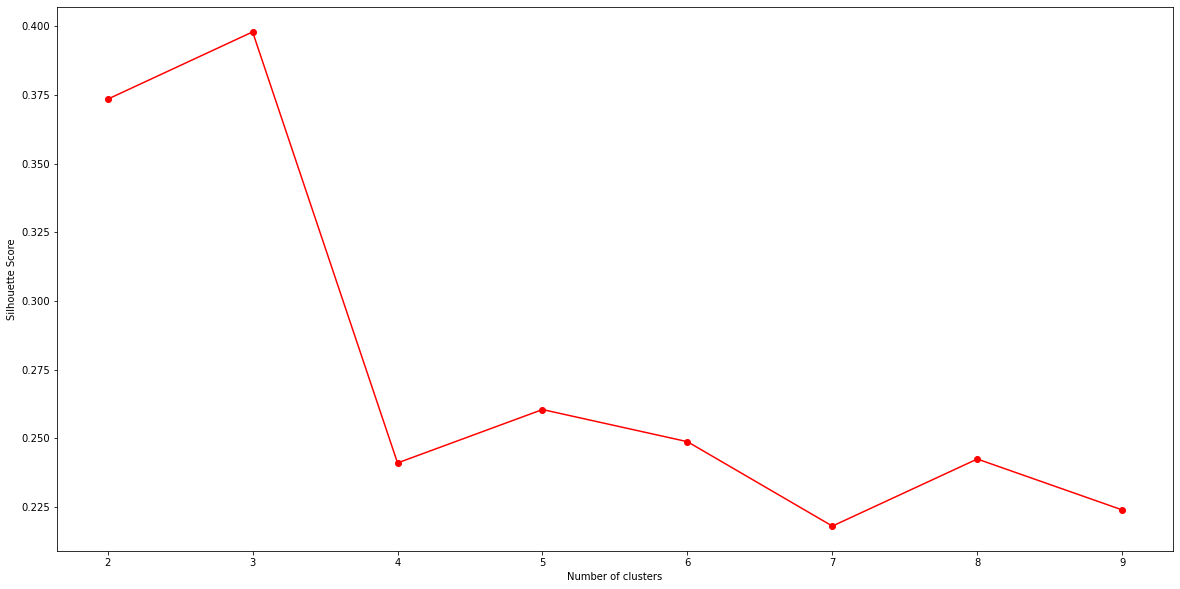

In [21]:
Lagos_grouped_clustering = Lagos_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(Lagos_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(Lagos_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

As seen from the above line plot, the best number of clusters having the highest silhouette score is 2. So, lets consider the number of clusters as 2.

In [22]:
# select best number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Lagos_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 6, 5, 2, 3, 8, 1, 1, 7])

Add the cluster labels to the neighborhoods_venues_sorted dataframe. And lets create a new datframe Lagos_merged which has the neighborhood details, cluster labels and the 10 most common venues in that neighborhood.

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Lagos_merged = Lagos_venues_top[Lagos_venues_top.columns[0:3]].drop_duplicates()
Lagos_merged.reset_index(drop = True, inplace = True)

# merge Lagos_grouped with df_Lagos to add latitude/longitude for each neighborhood
Lagos_merged = Lagos_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Lagos_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alimosho,6.584343,3.257631,6,Fast Food Restaurant,Airport Lounge,Shopping Mall,Lounge,Pizza Place,Hotel,Park,Market,Restaurant,Burger Joint
1,Ajeromi-Ifelodun,6.455122,3.335946,2,Hotel,Pizza Place,Lounge,African Restaurant,Shopping Mall,Park,Movie Theater,Chinese Restaurant,Nightclub,Fast Food Restaurant
2,Kosofe,6.581974,3.414836,7,Fast Food Restaurant,Shopping Mall,Bar,Restaurant,Convenience Store,Pizza Place,Nightclub,African Restaurant,Chinese Restaurant,BBQ Joint
3,Mushin,50.518229,3.291654,4,Soccer Field,Train Station,French Restaurant,Bagel Shop,Auto Garage,Liquor Store,Basketball Stadium,Sports Bar,Indian Restaurant,Automotive Shop
4,Oshodi-Isolo,6.540010,3.312415,7,Fast Food Restaurant,Shopping Mall,African Restaurant,Hotel,Pizza Place,Bar,Restaurant,Bakery,Nightclub,Lounge


## Results <a name="results"></a>

Let’s examine the clusters and find the discriminating venue categories that distinguish each cluster. For this purpose lets also print the ten most common venue category in each cluster.

#### Cluster 1

In [24]:
Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 0, Lagos_merged.columns[[0] + list(range(4, Lagos_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Ojo,Restaurant,Eastern European Restaurant,Mediterranean Restaurant,Supermarket,Diner,Border Crossing,Resort,Casino,Nature Preserve,Women's Store


In [25]:
cluster1 = Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 0, Lagos_merged.columns[[0] + 
                                                                                    list(range(4, Lagos_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Nature Preserve                1
Women's Store                  1
Casino                         1
Diner                          1
Restaurant                     1
Resort                         1
Mediterranean Restaurant       1
Eastern European Restaurant    1
Border Crossing                1
Supermarket                    1
dtype: int64


#### Cluster 2

In [26]:
Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 1, Lagos_merged.columns[[0] + list(range(4, Lagos_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Agege,Fast Food Restaurant,Shopping Mall,Hotel,Lounge,Restaurant,Convenience Store,Pizza Place,Bar,African Restaurant,BBQ Joint
8,Ifako-Ijaiye,Fast Food Restaurant,Shopping Mall,Hotel,Performing Arts Venue,Burger Joint,Bus Station,Restaurant,Beer Garden,Chinese Restaurant,Convenience Store
12,Ikeja,Fast Food Restaurant,Pizza Place,Shopping Mall,Bar,Hotel,Department Store,Convenience Store,Lounge,Restaurant,BBQ Joint


In [27]:
cluster2 = Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 1, Lagos_merged.columns[[0] + 
                                                                                    list(range(4, Lagos_merged.shape[1]))]]
venues2 = (cluster1['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Restaurant            4
Convenience Store     3
Shopping Mall         3
Hotel                 3
Lounge                2
Bar                   2
BBQ Joint             2
Pizza Place           2
Chinese Restaurant    1
Beer Garden           1
dtype: int64


#### Cluster 3

In [28]:
Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 2, Lagos_merged.columns[[0] + list(range(4, Lagos_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Ajeromi-Ifelodun,Hotel,Pizza Place,Lounge,African Restaurant,Shopping Mall,Park,Movie Theater,Chinese Restaurant,Nightclub,Fast Food Restaurant
6,Surulere,Hotel,Lounge,Shopping Mall,Pizza Place,Nightclub,Department Store,Bar,African Restaurant,Fast Food Restaurant,Asian Restaurant
11,Lagos Mainland,Shopping Mall,Lounge,Hotel,African Restaurant,Department Store,Pizza Place,Nightclub,Art Gallery,Fast Food Restaurant,Bar
14,Apapa,Hotel,Lounge,African Restaurant,Ice Cream Shop,Pizza Place,Art Gallery,Nightclub,Restaurant,Café,Mexican Restaurant


In [29]:
cluster3 = Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 2, Lagos_merged.columns[[0] + 
                                                                                    list(range(4, Lagos_merged.shape[1]))]]
venues3 = (cluster1['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Nightclub               4
Lounge                  4
Pizza Place             4
African Restaurant      4
Fast Food Restaurant    3
Shopping Mall           2
Restaurant              2
Art Gallery             2
Department Store        2
Bar                     2
dtype: int64


#### Cluster 4

In [30]:
Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 3, Lagos_merged.columns[[0] + list(range(4, Lagos_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Epe,Restaurant,Hotel,Café,Supermarket,History Museum,Spa,Dessert Shop,Campground,Bus Stop,Discount Store


In [31]:
cluster4 = Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 3, Lagos_merged.columns[[0] + 
                                                                                    list(range(4, Lagos_merged.shape[1]))]]
venues4 = (cluster1['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Dessert Shop      1
Campground        1
Café              1
Supermarket       1
Restaurant        1
Spa               1
Bus Stop          1
Discount Store    1
Hotel             1
History Museum    1
dtype: int64


#### Cluster 5

In [32]:
Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 4, Lagos_merged.columns[[0] + list(range(4, Lagos_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Mushin,Soccer Field,Train Station,French Restaurant,Bagel Shop,Auto Garage,Liquor Store,Basketball Stadium,Sports Bar,Indian Restaurant,Automotive Shop


In [33]:
cluster5 = Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 4, Lagos_merged.columns[[0] + 
                                                                                    list(range(4, Lagos_merged.shape[1]))]]
venues5 = (cluster1['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Indian Restaurant     1
Train Station         1
Bagel Shop            1
French Restaurant     1
Restaurant            1
Automotive Shop       1
Sports Bar            1
Auto Garage           1
Basketball Stadium    1
Liquor Store          1
dtype: int64


#### Cluster 6

In [34]:
Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 5, Lagos_merged.columns[[0] + list(range(4, Lagos_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Amuwo-Odofin,Hotel,Shopping Mall,Park,Fast Food Restaurant,African Restaurant,Bakery,Chinese Restaurant,Music Venue,Pool,Resort


In [35]:
cluster6 = Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 5, Lagos_merged.columns[[0] + 
                                                                                    list(range(4, Lagos_merged.shape[1]))]]
venues6 = (cluster1['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Shopping Mall           1
Park                    1
African Restaurant      1
Fast Food Restaurant    1
Bakery                  1
Restaurant              1
Music Venue             1
Pool                    1
Resort                  1
Chinese Restaurant      1
dtype: int64


#### Cluster 7

In [36]:
Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 6, Lagos_merged.columns[[0] + list(range(4, Lagos_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alimosho,Fast Food Restaurant,Airport Lounge,Shopping Mall,Lounge,Pizza Place,Hotel,Park,Market,Restaurant,Burger Joint


In [37]:
cluster7 = Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 6, Lagos_merged.columns[[0] + 
                                                                                    list(range(4, Lagos_merged.shape[1]))]]
venues7 = (cluster1['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

Restaurant        2
Shopping Mall     1
Park              1
Market            1
Burger Joint      1
Lounge            1
Pizza Place       1
Hotel             1
Airport Lounge    1
dtype: int64


#### Cluster 8

In [38]:
Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 7, Lagos_merged.columns[[0] + list(range(4, Lagos_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Kosofe,Fast Food Restaurant,Shopping Mall,Bar,Restaurant,Convenience Store,Pizza Place,Nightclub,African Restaurant,Chinese Restaurant,BBQ Joint
4,Oshodi-Isolo,Fast Food Restaurant,Shopping Mall,African Restaurant,Hotel,Pizza Place,Bar,Restaurant,Bakery,Nightclub,Lounge
9,Somolu,Fast Food Restaurant,Shopping Mall,Pizza Place,African Restaurant,Bar,Lounge,Restaurant,Department Store,Nightclub,Hotel


In [39]:
cluster8 = Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 7, Lagos_merged.columns[[0] + 
                                                                                    list(range(4, Lagos_merged.shape[1]))]]
venues8= (cluster1['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))

print(venues8.value_counts().head(10))

Restaurant            4
African Restaurant    3
Pizza Place           3
Shopping Mall         3
Bar                   3
Nightclub             3
Lounge                2
Hotel                 2
Chinese Restaurant    1
Convenience Store     1
dtype: int64


#### Cluster 9

In [40]:
Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 8, Lagos_merged.columns[[0] + list(range(4, Lagos_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Eti-Osa,Hotel,Lounge,Beach,Fast Food Restaurant,Department Store,Shopping Mall,Convenience Store,Chinese Restaurant,Ice Cream Shop,Pizza Place
15,Lagos Island,Hotel,Lounge,Department Store,Ice Cream Shop,Chinese Restaurant,Beach,Convenience Store,Shopping Mall,Bus Station,Clothing Store


In [41]:
cluster9 = Lagos_merged.loc[Lagos_merged['Cluster Labels'] == 8, Lagos_merged.columns[[0] + 
                                                                                    list(range(4, Lagos_merged.shape[1]))]]
venues9 = (cluster1['1st Most Common Venue'].append(
    cluster9['2nd Most Common Venue']).append(
    cluster9['3rd Most Common Venue']).append(
    cluster9['4th Most Common Venue']).append(
    cluster9['5th Most Common Venue']).append(
    cluster9['6th Most Common Venue']).append(
    cluster9['7th Most Common Venue']).append(
    cluster9['8th Most Common Venue']).append(
    cluster9['9th Most Common Venue']).append(
    cluster9['10th Most Common Venue']))

print(venues9.value_counts().head(10))

Shopping Mall           2
Chinese Restaurant      2
Beach                   2
Department Store        2
Convenience Store       2
Lounge                  2
Ice Cream Shop          2
Fast Food Restaurant    1
Clothing Store          1
Restaurant              1
dtype: int64


## Discussion <a name="discussion"></a>

We shall visulaize the top 5 most common venue categories in each of the cluster.

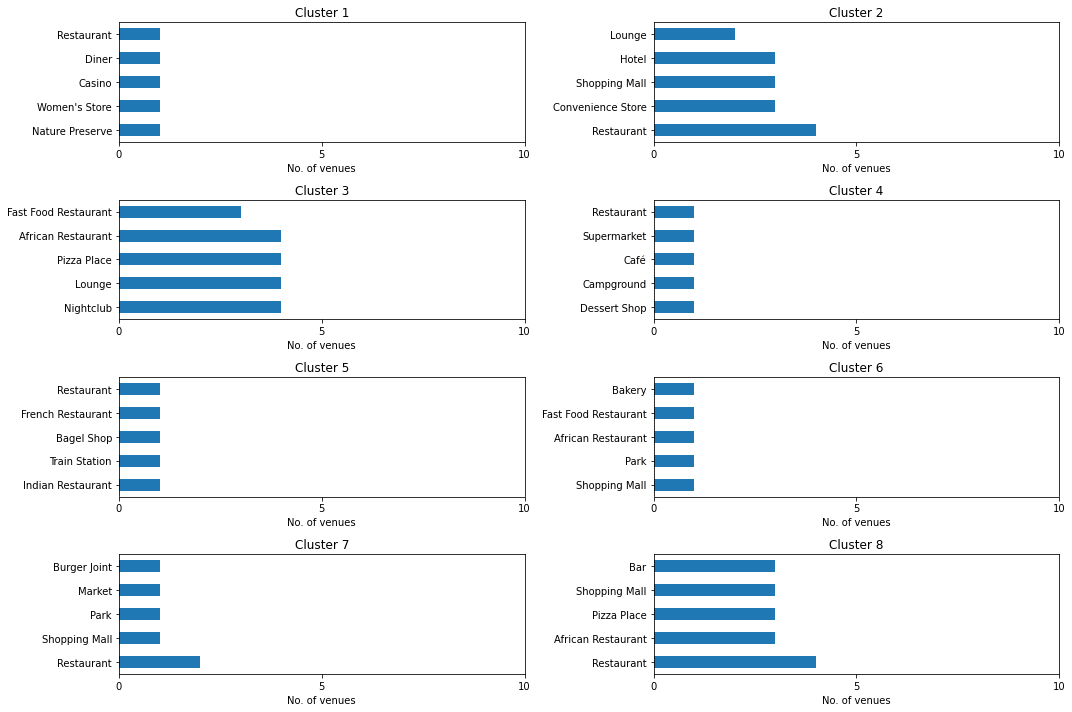

In [42]:
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues8, venues9]
fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

This plot can be used to suggest valuable information to Business persons. Let's discuss a few examples considering they would like to start the following category of business.

#### 1. Ice Cream Shop

The only neighborhoods cluster with the highest number of ice cream shop is 4 while the rest has few or none. Hence opening one in others will be a likely good move. 

#### 2. Pizza Place

Just like ice cream shop, only neighborhoods cluster 3 highest number of Pizza Place while the rest has few or none.


#### 3. African Restaurant 

Since Lagos is one of the biggest cities in Africa, once would expert all neighborhoods cluster to have good number of African restaurant, but base on this analysis only cluster 2 and 7 have.

#### Map of Lagos with the clusters superimposed on top

This map can be used to find a suitable location to start a new business based on the category.

In [43]:
# create map
Lagos_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Lagos_merged['Neighborhood Latitude'], Lagos_merged['Neighborhood Longitude'], Lagos_merged['Neighborhood'], Lagos_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Lagos_clusters_map)
       
Lagos_clusters_map

## Word Cloud <a name="word"></a> 

#### Next let's display the names of the Top 10 venues from each LGA in Lagos State, using the word cloud application.

The word cloud object emphasizes the most frequent words in a document or string, by making them bigger than others. In other words, the more frequent a word is in the word cloud object, the bigger the word becomes in comparison to other words.

In [44]:
from PIL import Image # Used for converting images into arrays

# import wordcloud package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Wordcloud is installed and imported!


We use the stopwords that we imported from word_cloud. We use the function set to remove any redundant stopwords.

Next, let's select only needed columns from the DataFrame for our wordCloud object

In [45]:
stopwords = set(STOPWORDS)

# Let's select only the columns in lagos_merged DataFrame that we need
selection = Lagos_merged.iloc[:, 4:]

# Let's view the first 5 rows of our selection
#selection.head()

Next, let's create a string object with all the venue category words from the DataFrame showing the first 10 Top categories per LGA (Lagos_merged).

In [46]:
# Next lets write code to iterate through each column of our selection DataFrame and append each category word to a string object

col_list = list(selection.columns)

words = ''

for i in col_list:
    for j in list(selection[i]):
        words += j
        words += ', '

print(len(words))
#words

2300


In [47]:
# Create a word cloud object and generate a word cloud.

# Instantiate a WordCloud object
top_venues_wc = WordCloud(
          background_color='white',
          max_words= len(words),
          stopwords=stopwords)

# Generate the WordCloud
top_venues_wc.generate(words)

Now that the word cloud is created, let's visualize it.

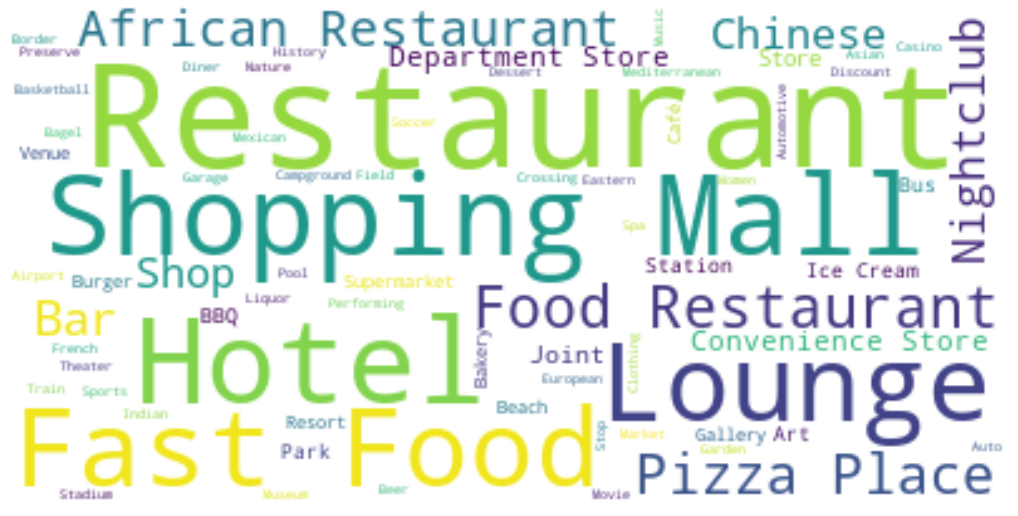

In [48]:
# Generate the WordCloud
top_venues_wc.generate(words)

# Set the Size
plt.figure(figsize=(18, 22))

# Display the WC
plt.imshow(top_venues_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

The most common or frequent venues in all of Lagos State are:-
<br>**Restaurant**,
<br>**Lounge**,
<br>**Fast Food**,
<br>**Hotel**,
<br>**Food Restaurant**,
<br>Others include Pizza Place, Shopping Mall, African restaurant, Chinese Restaurant, Cream Shop, Bus Station, E.t.c.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to analyze the neighborhoods of Lagos, Nigeria and create a clustering model to suggest personals places to start a new business based on the category. The neighborhoods data was obtained from an Wikipedia and the Foursquare API was used to find the major venues in each neighborhood. But we found that many neighborhoods had less than 10 venues returned. In order to build a good Data Science model, we filtered out these locations. The remaining locations were used to create a clustering model. The best number of clusters was obtained using the silhouette score. Each cluster was examined to find the most venue categories present, that defines the characteristics for that particular cluster.

A few examples for the applications that the clusters can be used for have also been discussed. Stakeholders can use this project to decide the location for the particular type of business.


### A possible shortfall of this exercise.

A major drawback of this project was that the Foursquare API returned only few venues in each neighborhood. As a future improvement, better data sources can be used to obtain more venues in each neighborhood. This way the neighborhoods that were filtered out can be included in the clustering analysis to create a better decision model.

## Thank you

I hope you found the project useful and interesting. Feel free to contact me if you have any queries or suggestions.

This notebook was developed by [Adebayo Amodu](https://www.linkedin.com/in/adebayo-amodu-amicheme-b7aba988/). 